In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## GTZAN Dataset

This work aims to analyze the GTZAN database (https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification) and build a model that is capable of classify a wave file into a category of 10 music genres.

A few machine learning and deep learning models are built and compared.

In [10]:
data_df = pd.read_csv('/Users/laura/Documents/Perso/kaggle_music/data/features_3_sec.csv')
data_df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

# Data Observation

This database contains a list of 100 song snippet for 10 various genre of music. For each snippet we have :
- a wav audio file of a few seconds
- a list of feature representing the audio file on various level (spectral or temporal)
- an image of the spectral repersentation of the sound

Let's start with the feature set on a time window of 3s. This database is clean and does not contain missing or outlier values.

It is also well balanced between the different classes. We have 999 data points for each classes.

In [11]:
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

We can see that a lot of feature's name start with mfcc.

MFCC features represent phonemes (distinct units of sound) as the shape of the vocal tract (which is responsible for sound generation) is manifest in them.

The MFCC feature extraction technique includes windowing the signal, applying the Fast fourrier transform, taking the log of the magnitude, warping the frequencies on a Mel scale, and then applying the inverse Fast fourrier transform.

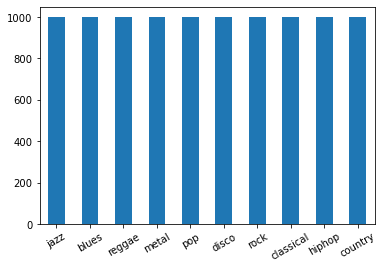

In [12]:
data_df.label.value_counts().plot(kind='bar', rot=30)

Looking at how the features are distributed help us to look for outliers data and remove a feature that would be too far away from a normal distribution.

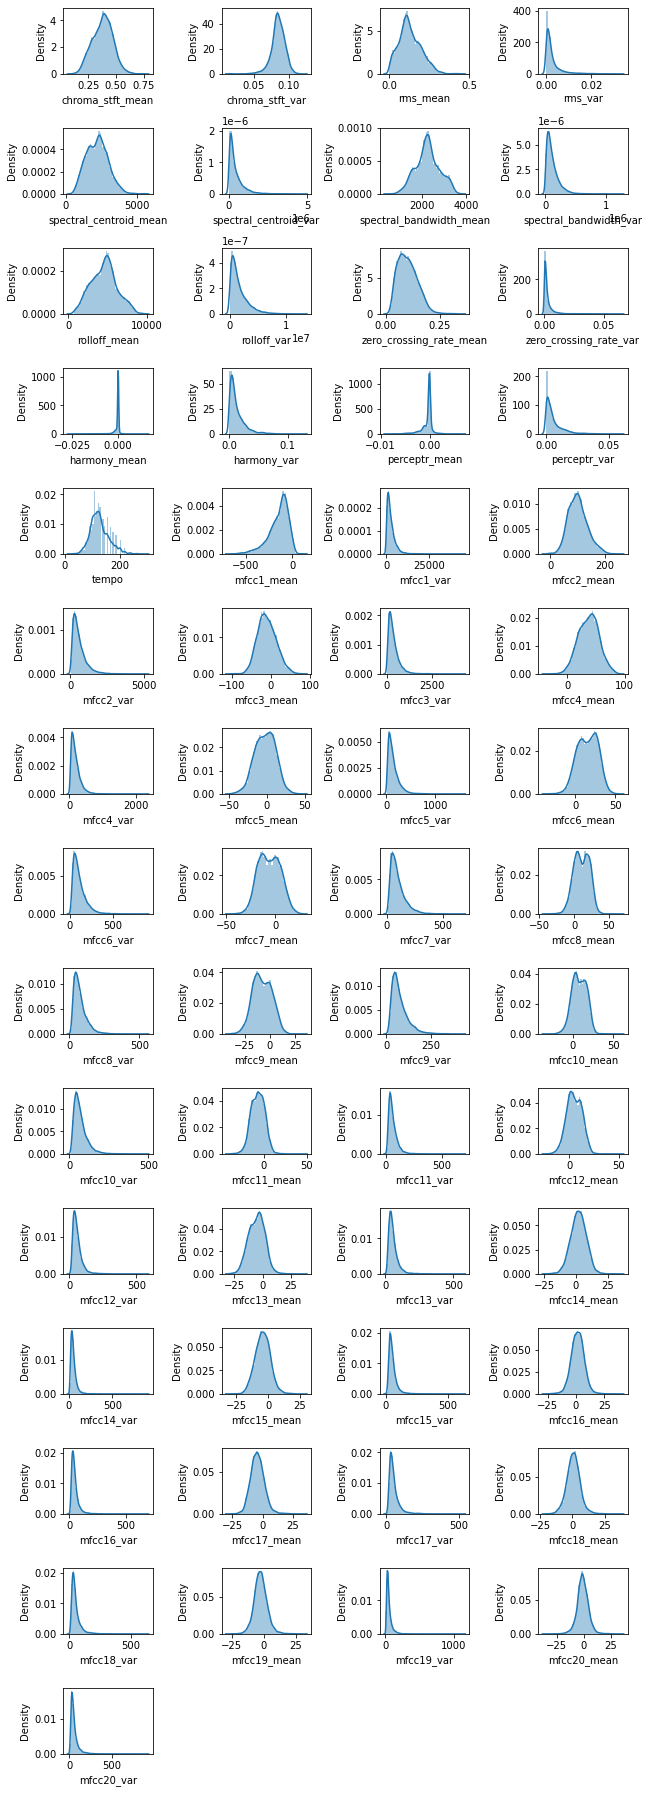

In [13]:
quant_col = ['filename', 'label', 'length']
quant_df = data_df.drop(quant_col, axis=1)
plt.figure(figsize=(9,25))
for i, column in enumerate(quant_df.columns, 1):
    plt.subplot(15,4,i)
    sns.distplot(quant_df[column])
plt.tight_layout()

# Feature selection

We have a high number of feature. We need to check if some of them are correlated and remove them.

In [14]:
#Features selection
# remove of length and filename
df = data_df.drop(['filename', 'length'], axis=1)

# check correlations between features and the target column
# check correlation with other features
# check the variance of features

def plot_corr_matrix(df):
    plt.figure(figsize=(15,15))
    corr_matrix = df.corr()
    
    mask = np.triu(np.ones_like(corr_matrix.corr()))
    ax = sns.heatmap(
        corr_matrix, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        mask=mask
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

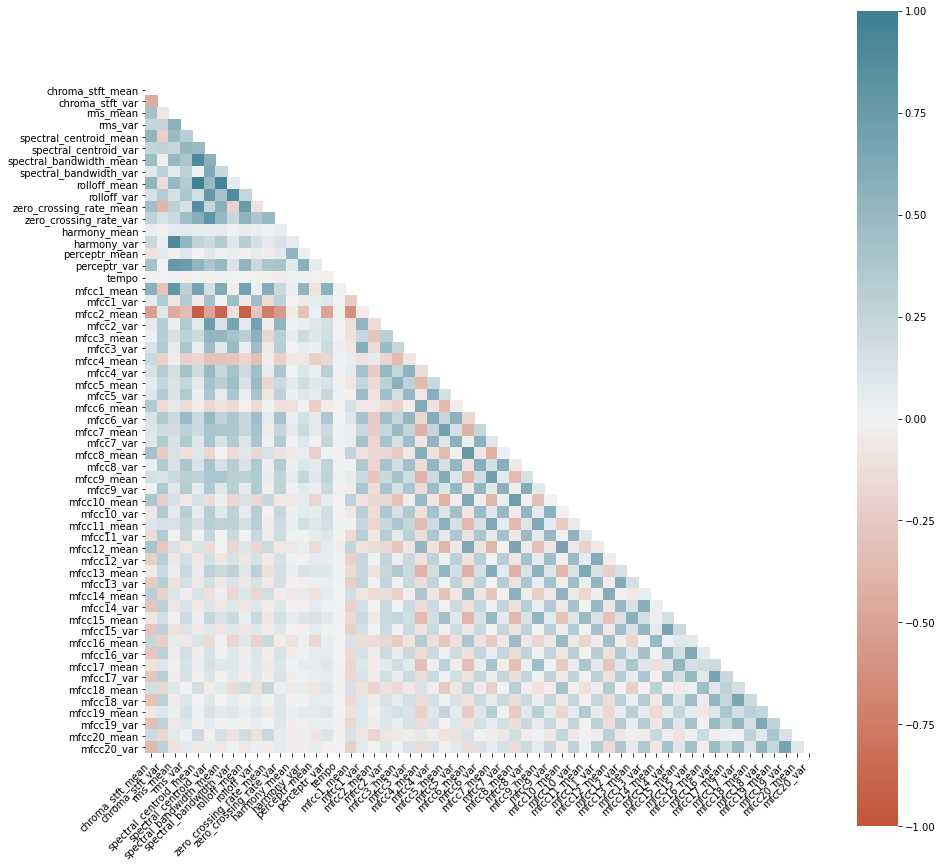

In [15]:
plot_corr_matrix(df)

In [16]:
# Remove strongly correlated features with a cutoff of 0.9
corr_matrix = df.corr()
tmp = corr_matrix.abs().unstack().sort_values(ascending = False)
abs_corr_matrix = corr_matrix.abs()
corr_df = abs_corr_matrix[abs_corr_matrix>0.9].unstack().dropna()

correlated_columns = []
for index, val in corr_df.iteritems():
    if index[0] != index[1]:
        correlated_columns.append(index)

corr_features = []
for item1 in correlated_columns:
    for item2 in correlated_columns:
        if ((item1[0] == item2[0]) and (item1[1] == item2[1])) or ((item1[0] == item2[1]) and (item1[1] == item2[0])):
            continue
        else:
            corr_features.append(item1)

df = data_df.drop(['filename', 'length', 'mfcc2_mean', 'rolloff_mean'], axis=1)
set(corr_features)

{('mfcc2_mean', 'rolloff_mean'),
 ('mfcc2_mean', 'spectral_centroid_mean'),
 ('rolloff_mean', 'mfcc2_mean'),
 ('rolloff_mean', 'spectral_bandwidth_mean'),
 ('rolloff_mean', 'spectral_centroid_mean'),
 ('spectral_bandwidth_mean', 'rolloff_mean'),
 ('spectral_centroid_mean', 'mfcc2_mean'),
 ('spectral_centroid_mean', 'rolloff_mean')}

A PCA on the resulting features help us understand how hard the problem is. Here we see that that visually, no clear cluster can be deduced. A simple model will not be enough to classify.

[0.23337853 0.18064169]


Text(0, 0.5, 'pc2')

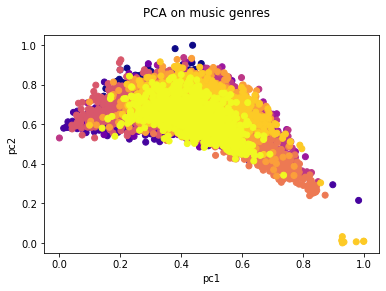

In [17]:
# Feature visualization
# PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

X = df.drop(['label'], axis =1)

le = LabelEncoder()
le.fit(df[['label']])
classes = le.classes_
y = le.transform(df[['label']])
y = y.astype(np.int32, copy=False)

# Standardize features by removing the mean and scaling to unit variance
scaler = MinMaxScaler()
scaler.fit(X)
X_norm = (scaler.transform(X))

NUM_OF_COMPONENTS = 2
pca=PCA(n_components=NUM_OF_COMPONENTS)
pca.fit(X_norm)
x = pca.transform(X_norm)
print(pca.explained_variance_ratio_)
fig = plt.figure()
fig.suptitle("PCA on music genres")

plt.scatter(X_norm[:,0],X_norm[:,1],c=y, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

# Database split

We do a 60% Train and 40% Test database split.

In [41]:
from sklearn.model_selection import train_test_split

# Train/test split
X = df.drop(['label'], axis =1)
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, shuffle=True)

## K nearest neighboor

Let's build our first model, with K nearest neighboor. This model computes the distance between an data and all others, select the K nearest and votes for the most frequent label.

After having tried a few number of neighboor, let's do an hyperparameter optimization of :
- leaf_size :
- p : 1 is manhattan distance, 2 is euclidian distance
- n_neighbors : number of closest neighboor we select the label

In [19]:
from sklearn.model_selection import GridSearchCV

#List Hyperparameters that we want to tune.
leaf_size = list(range(1,5))
n_neighbors = list(range(5,15))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=5)
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 5


Classification Report:
              precision    recall  f1-score   support

       blues       0.90      0.89      0.89       401
   classical       0.87      0.97      0.91       416
     country       0.83      0.83      0.83       424
       disco       0.83      0.92      0.87       395
      hiphop       0.92      0.88      0.90       390
        jazz       0.89      0.84      0.86       403
       metal       0.97      0.95      0.96       385
         pop       0.96      0.88      0.92       397
      reggae       0.87      0.92      0.89       400
        rock       0.89      0.82      0.86       385

    accuracy                           0.89      3996
   macro avg       0.89      0.89      0.89      3996
weighted avg       0.89      0.89      0.89      3996

Accuracy: 0.8898898898898899


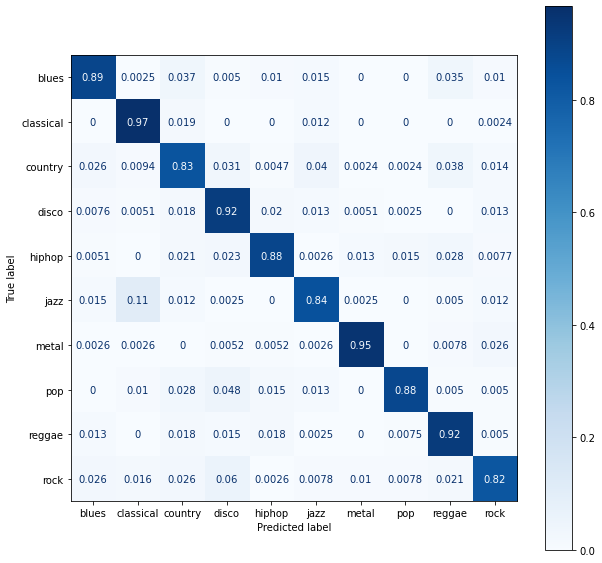

In [53]:
# KNN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(X_train) # Fit to train DB only because test DB has to be unknown for the model
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Train
knn = KNeighborsClassifier(n_neighbors = 5, leaf_size=1, p =1)
knn.fit(X_train_scale, y_train)

# Predict
y_pred = knn.predict(X_test_scale)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(knn, X_test_scale, y_test, normalize='true', cmap=plt.cm.Blues, ax=ax)

report = classification_report(y_test, y_pred)
print("Classification Report:",)
print(report)

# Ratio of correctly predicted observation to the total observations
acc_score = accuracy_score(y_test,y_pred)
print("Accuracy:",acc_score)

This first model is quite good, with an accuracy of 0.89. We can see that we do the most error between the jazz datasets and classical.

This error can be understood as classical and jazz music often contains the same sound and instrument signature.

## Random Forest

Let's try a random forest model. Random forest builds randomly small decision tree and train them on random small boostrap dataset. 
It then ensemble all the small "weak" decision tree to obtain a strong classifier.

In [68]:
# Random forest

#List Hyperparameters that we want to tune.
n_estimators = list(range(200, 2000, 100))
max_depth = list([2,4,8,16,32])
#Convert to dictionary
# hyperparameters = dict(max_depth=max_depth) n_estimators=n_estimators, 
#Create new RF object
rf_2 = RandomForestClassifier()
#Use GridSearch
clf = GridSearchCV(rf_2, hyperparameters, cv=5)
#Fit the model
best_model = clf.fit(X, y)
#Print The value of best Hyperparameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Best n_estimators: 1800
Best max_depth: None


Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.87      0.88       401
   classical       0.90      0.96      0.93       416
     country       0.83      0.80      0.82       424
       disco       0.83      0.83      0.83       395
      hiphop       0.89      0.84      0.86       390
        jazz       0.83      0.90      0.86       403
       metal       0.85      0.93      0.89       385
         pop       0.89      0.86      0.88       397
      reggae       0.84      0.86      0.85       400
        rock       0.85      0.74      0.79       385

    accuracy                           0.86      3996
   macro avg       0.86      0.86      0.86      3996
weighted avg       0.86      0.86      0.86      3996

Accuracy: 0.8593593593593594


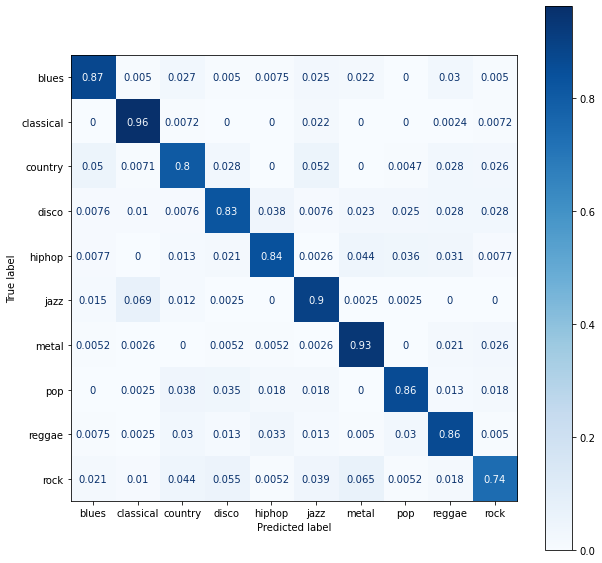

In [69]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1800, random_state = 42, max_depth=None)

# Train on non scale data
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X)

# Evaluate
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, X_test, y_test, normalize='true', cmap=plt.cm.Blues, ax=ax)

report = classification_report(y_test, y_pred)
print("Classification Report:",)
print(report)

# Ratio of correctly predicted observation to the total observations
acc_score = accuracy_score(y_test,y_pred)
print("Accuracy:",acc_score)

## Multi layer perceptron



Classification Report:
              precision    recall  f1-score   support

       blues       0.87      0.84      0.86       401
   classical       0.92      0.92      0.92       416
     country       0.83      0.82      0.83       424
       disco       0.86      0.84      0.85       395
      hiphop       0.88      0.89      0.88       390
        jazz       0.84      0.89      0.86       403
       metal       0.93      0.94      0.93       385
         pop       0.91      0.88      0.90       397
      reggae       0.87      0.88      0.87       400
        rock       0.80      0.81      0.81       385

    accuracy                           0.87      3996
   macro avg       0.87      0.87      0.87      3996
weighted avg       0.87      0.87      0.87      3996

Accuracy: 0.8708708708708709


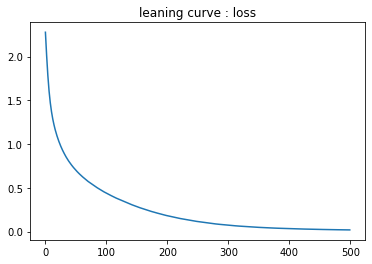

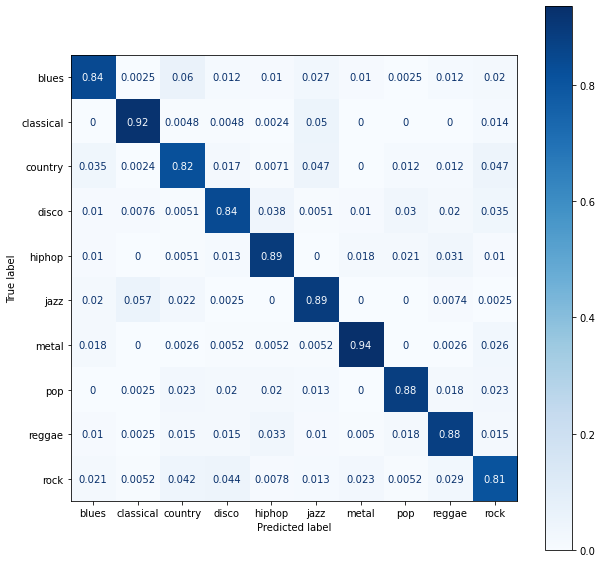

In [70]:
#MLP
from sklearn.neural_network import MLPClassifier

# loss = log loss
mlp = MLPClassifier( hidden_layer_sizes=(500,500,300), max_iter=500,
                     solver='sgd', verbose=False,  random_state=21)

# Train
mlp.fit(X_train_scale, y_train)

# Predict
y_pred = mlp.predict(X_test_scale)

plt.plot(mlp.loss_curve_)
plt.title('leaning curve : loss')

# Evaluate
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(mlp, X_test_scale, y_test, normalize='true', cmap=plt.cm.Blues, ax=ax)

report = classification_report(y_test, y_pred)
print("Classification Report:",)
print(report)

# Ratio of correctly predicted observation to the total observations
acc_score = accuracy_score(y_test,y_pred)
print("Accuracy:", acc_score)

## Models comparisons

We need to compare the performances of all these different models.

To do so, we do a 10 fold cross validation. It will split the whole dataset into 10 split, and each iteration, select 1 split as test set and the rest as train.

In [58]:
# Model selection
from sklearn import model_selection

df_shuffle = df.sample(frac = 1)
X = df_shuffle.drop(['label'], axis =1)
y = df_shuffle[['label']]

scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)

results = []
names = []

seed = 42
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(knn, X_scale, y, cv=kfold, scoring='accuracy')
results.append(cv_results)
names.append('KNN')

cv_results = model_selection.cross_val_score(rf, X, y, cv=kfold, scoring='accuracy')
results.append(cv_results)
names.append('RF')

cv_results = model_selection.cross_val_score(mlp, X_scale, y, cv=kfold, scoring='accuracy')
results.append(cv_results)
names.append('MLP')


Text(0.5, 1.0, 'Accuracy on 10-Fold')

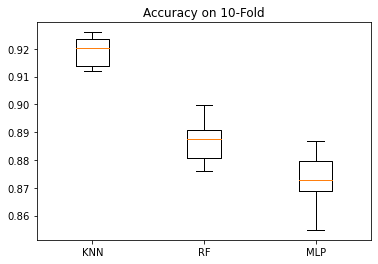

In [59]:
fig, ax = plt.subplots()
plt.boxplot(results)
ax.set_xticklabels(names)
plt.title('Accuracy on 10-Fold')

## Deep learning model

In this dataset, for each sound, we have an image of its Mel Spectrogram. Mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.

The Mel scale, is a unit of pitch such that equal distances in pitch sounded equally distant to the listener.

As we have those images, we can build and train a CNN (Convolution Neural Network). CNN works well with image classification, as it is able to capture information in large context and small details.

Let's first train a CNN from scratch with only our data, then, let's use a model trained on imagenet and do transfer learning.

Found 999 files belonging to 10 classes.


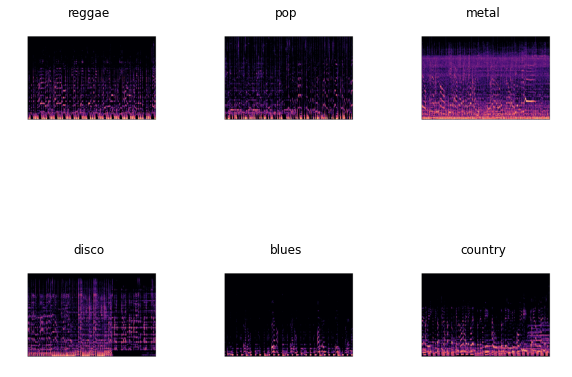

In [3]:
import tensorflow as tf
import pathlib

# Load images
data_path = '/Users/lauraperso/Documents/GitHub/gtzan_db/data/images_original'
data_dir = pathlib.Path(data_path)
img_height = 288
img_width = 432
batch_size = 32

data_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                validation_split=None,
                                                                subset=None,
                                                                seed=123,
                                                                image_size=(img_height, img_width),
                                                                batch_size=batch_size,
                                                                shuffle=True)


class_names = data_ds.class_names
plt.figure(figsize=(10, 8))
for images, labels in data_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = data_ds.map(lambda x, y: (normalization_layer(x), y))

# Split train, validation, test DB
db_size = 999
train_size = 699
val_size = 150
test_size = 150

normalized_ds_unb = normalized_ds.unbatch()
train_dataset = normalized_ds_unb.take(train_size).batch(batch_size)
test_dataset = normalized_ds_unb.skip(train_size)
val_dataset = test_dataset.skip(test_size).batch(batch_size)
test_dataset = test_dataset.take(test_size)


In [7]:
# Build CNN model

num_classes = len(class_names)
epochs_number = 20
# earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), # from_logits=True then need softmax before predicting 
  metrics=['accuracy'])

log = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_number) #, callbacks=[earlystop_callback]

Epoch 1/20
22/22 [==============================] - 67s 3s/step - loss: 5.6604 - accuracy: 0.1512 - val_loss: 2.2451 - val_accuracy: 0.1133
Epoch 2/20
22/22 [==============================] - 73s 3s/step - loss: 2.1108 - accuracy: 0.2357 - val_loss: 1.8245 - val_accuracy: 0.3200
Epoch 3/20
22/22 [==============================] - 62s 3s/step - loss: 1.6805 - accuracy: 0.4320 - val_loss: 1.4403 - val_accuracy: 0.4667
Epoch 4/20
22/22 [==============================] - 69s 3s/step - loss: 1.2106 - accuracy: 0.5859 - val_loss: 1.2067 - val_accuracy: 0.6533
Epoch 5/20
22/22 [==============================] - 68s 3s/step - loss: 0.8334 - accuracy: 0.7337 - val_loss: 0.8949 - val_accuracy: 0.7333
Epoch 6/20
22/22 [==============================] - 65s 3s/step - loss: 0.5109 - accuracy: 0.8418 - val_loss: 0.7480 - val_accuracy: 0.7400
Epoch 7/20
22/22 [==============================] - 65s 3s/step - loss: 0.2125 - accuracy: 0.9495 - val_loss: 0.7280 - val_accuracy: 0.7667
Epoch 8/20
22/22 [==

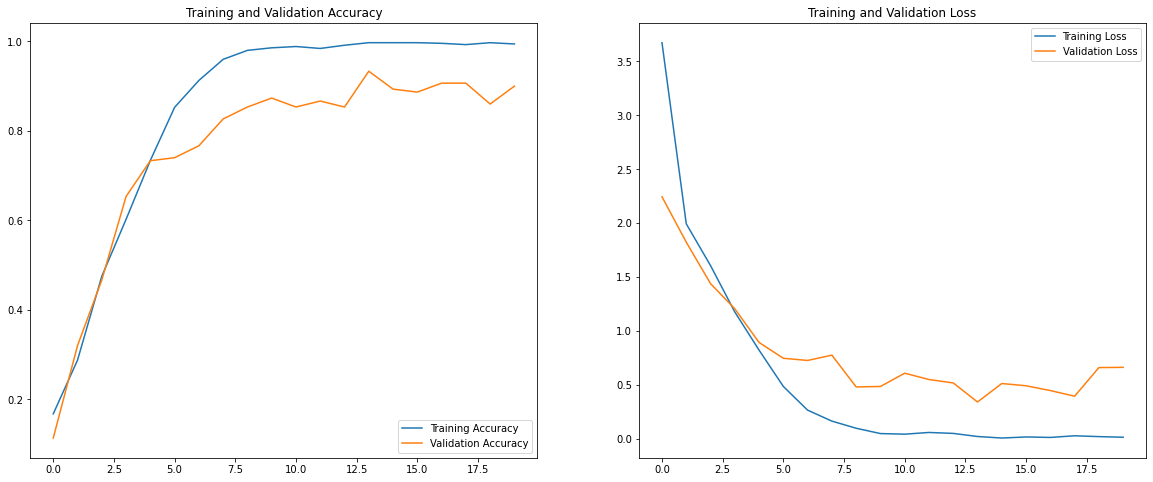

In [8]:
acc = log.history['accuracy']
val_acc = log.history['val_accuracy']

loss = log.history['loss']
val_loss = log.history['val_loss']

epochs_range = range(epochs_number)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
model.evaluate(test_dataset.batch(batch_size))

5/5 [==============================] - 8s 609ms/step - loss: 0.7406 - accuracy: 0.8867


[0.7405546307563782, 0.8866666555404663]

Text(33.0, 0.5, 'Actual Values ')

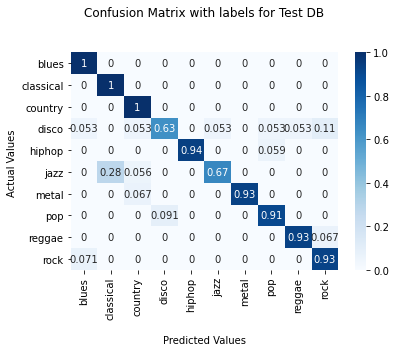

In [63]:
predictions = np.array([])
labels = np.array([])
for x, y in test_dataset:
   predictions = np.concatenate([predictions, model.predict_classes(tf.expand_dims(x, axis=0))])
   labels = np.concatenate([labels, [y.numpy()]])

cf_m = tf.math.confusion_matrix(labels = labels, predictions = predictions).numpy()
cf_mm = cf_m.astype('float') / cf_m.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cf_mm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix with labels for Test DB\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

We can see that the classifier performs well for most of the classes except for the disco and jazz.

Text(33.0, 0.5, 'Actual Values ')

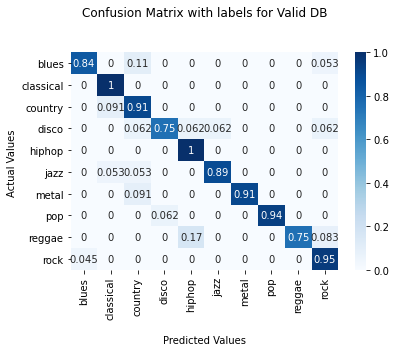

In [65]:
predictions = np.array([])
labels = np.array([])
for x, y in val_dataset.unbatch():
   predictions = np.concatenate([predictions, model.predict_classes(tf.expand_dims(x, axis=0))])
   labels = np.concatenate([labels, [y.numpy()]])

cf_m = tf.math.confusion_matrix(labels = labels, predictions = predictions).numpy()
cf_mm = cf_m.astype('float') / cf_m.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cf_mm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix with labels for Valid DB\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Transfer learning

Let's see if it is possible to achieve higher perfomances with a model already trained on 2D images (imageNet) and that would be efficient on catching basic features.

wip